In [ ]:
# --- Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
# Load the dataset
file_path = '/content/Dataset.xlsx'
data = pd.read_excel(file_path)

In [ ]:
# Define input features and target
X = data[['Al', 'Ni', 'Cr', 'Fe', 'Co']]
y = data['Y/ρ']

In [ ]:
# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# --- Cross-validation setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# --- Containers to store results ---
cv_results = {}
train_test_results = {}

In [ ]:
# --- Helper function to train, cross-validate and evaluate models ---
def evaluate_model(name, model):
    # Cross-validation R2 scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    cv_results[name] = cv_scores

    # Train on full training set
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Train and Test Performance
    train_test_results[name] = {
        'Train_R²': r2_score(y_train, y_train_pred),
        'Test_R²': r2_score(y_test, y_test_pred),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred)
    }

In [ ]:
# --- 2. Support Vector Regression (SVR) ---
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])
svr_params = {'svr__C': [0.1, 1, 10], 'svr__epsilon': [0.01, 0.1, 0.2], 'svr__kernel': ['rbf']}
svr_grid = GridSearchCV(svr_pipe, svr_params, cv=kf, scoring='r2')
evaluate_model('SVR', svr_grid)

In [ ]:
# --- 3. Random Forest Regressor ---
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=kf, scoring='r2')
evaluate_model('Random Forest', rf_grid)

In [ ]:
# --- 4. Bagging Regressor ---
bag_params = {'n_estimators': [10, 50, 100]}
bag_grid = GridSearchCV(BaggingRegressor(random_state=42), bag_params, cv=kf, scoring='r2')
evaluate_model('Bagging Regressor', bag_grid)

In [ ]:
# --- 5. XGBoost Regressor ---
xgb_params = {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), xgb_params, cv=kf, scoring='r2')
evaluate_model('XGBoost', xgb_grid)

In [ ]:
# --- 6. Gaussian Process Regressor (GPR) ---
kernel = C(1.0) * RBF(length_scale=1.0)
gpr = Pipeline([
    ('scaler', StandardScaler()),
    ('gpr', GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True))
])
evaluate_model('GPR', gpr)

In [ ]:
# --- Display Cross-validation Results ---
print("\n--- 5-Fold CV R2 Scores ---")
for model_name, scores in cv_results.items():
    print(f"{model_name}: Mean R2 = {scores.mean():.3f}, Std = {scores.std():.3f}")


--- 5-Fold CV R2 Scores ---
SVR: Mean R2 = 0.890, Std = 0.063
Random Forest: Mean R2 = 0.877, Std = 0.052
Bagging Regressor: Mean R2 = 0.892, Std = 0.056
XGBoost: Mean R2 = 0.913, Std = 0.054
GPR: Mean R2 = 0.985, Std = 0.010


In [ ]:
train_test_results

{'SVR': {'Train_R²': 0.9997553853452189,
  'Test_R²': 0.9856992608264245,
  'Train_MAE': 0.01918707461442066,
  'Test_MAE': 0.21841617160285737},
 'Random Forest': {'Train_R²': 0.9850015739843533,
  'Test_R²': 0.9247708573336403,
  'Train_MAE': 0.2513887199459672,
  'Test_MAE': 0.5242361672415161},
 'Bagging Regressor': {'Train_R²': 0.9852805102687144,
  'Test_R²': 0.916852746795032,
  'Train_MAE': 0.24750303749222333,
  'Test_MAE': 0.5398014250896751},
 'XGBoost': {'Train_R²': 0.9994634436938377,
  'Test_R²': 0.8613274937737648,
  'Train_MAE': 0.04335208146151336,
  'Test_MAE': 0.7363636687013748},
 'GPR': {'Train_R²': 0.9972315436048658,
  'Test_R²': 0.9877141000446811,
  'Train_MAE': 0.10953727266720412,
  'Test_MAE': 0.19357782151532343}}

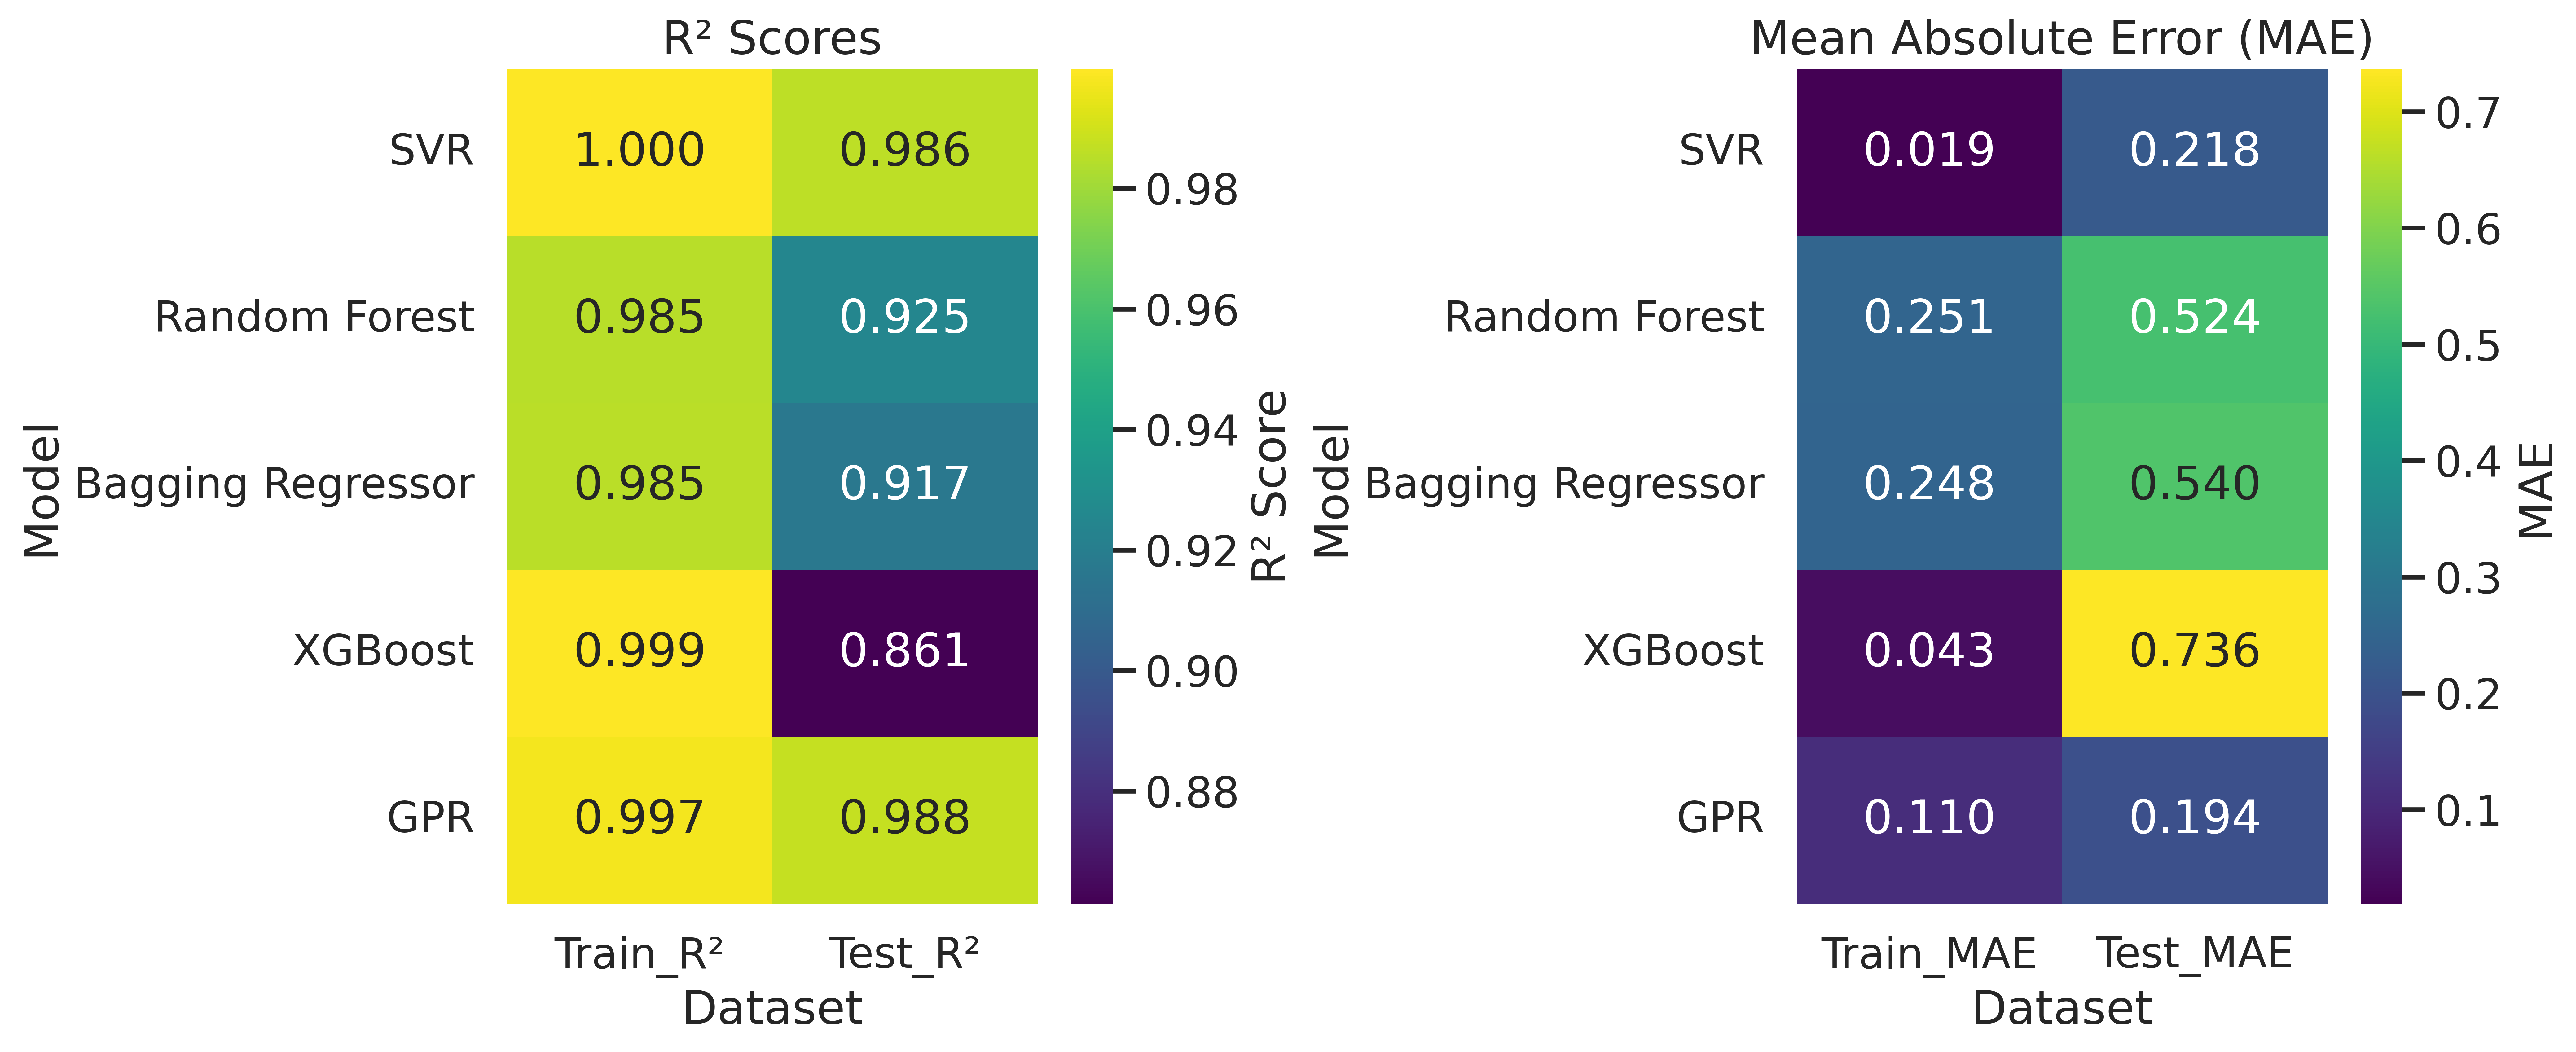

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use a clean, professional style
sns.set(style="whitegrid", context="talk", font_scale=1.0)

# Create a DataFrame from the train_test_results dictionary
results_df = pd.DataFrame(train_test_results).T

# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=600)

# Heatmap for R2 scores
sns.heatmap(
    results_df[['Train_R²', 'Test_R²']],
    annot=True, fmt=".3f", cmap='viridis',
    ax=axes[0], cbar_kws={'label': 'R² Score'}
)
axes[0].set_title('R² Scores')
axes[0].set_ylabel('Model')
axes[0].set_xlabel('Dataset')

# Heatmap for MAE scores
sns.heatmap(
    results_df[['Train_MAE', 'Test_MAE']],
    annot=True, fmt=".3f", cmap='viridis',
    ax=axes[1], cbar_kws={'label': 'MAE'}
)
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_ylabel('Model')
axes[1].set_xlabel('Dataset')

plt.tight_layout()

# Optional: Save to a file
plt.savefig('model_performance_heatmaps.png', dpi=300, bbox_inches='tight')

plt.show()